***
## Predicting fuel consumption using machine learning for container ship - Case Study
#### *Ranjeet Sandhu*
***

### Contents

1. Project and data overview
2. Exploratory data analysis
3. Data anomalies and interpretation
4. Summary statistics
5. Distribution analysis
6. Correlation analysis
7. Predictive modeling strategy and implementation
8. Machine learning models
9. Predictive model preformance analysis
10. Conclusion and opportunities

### Project and data overview

**Goal**: Predict the fuel consumption of ships for voyages to help ships operate at most efficient level.

**Objective**: Create a performance model of “LPG-VLGC” ship to predict the rate of fuel consumption on a set of features. The Machine Learning techniques are used to model the relationship across sensor, environmental data and fuel consumption rate. The trained hypotheses will be used to score a range of speeds and evaluate the predictive performance.

**Context**: Engine’s fuel cost is the major expenses for sea voyages; hence the accurate prediction is one of the prominent challenges in the maritime industry. The variability in the numerous operating and environmental factors impacting fuel consumption adds complexity to the issue; requiring a scientific problem-solving approach.

**Data**: The data are collected from a large LPG-VLGC ship’s sensors from “07-06-2017” to “05-14-2019”, which is down-sampled to the hourly records. The data has 16,248 samples containing the following features:
Fuel consumption rate in metric tons per day. Ship’s engine performance metrics such as shaft speed, shaft power and torque. Fuel type – heavy fuel or marine gas, former is used in open ocean and latter near coastal areas.
Ship’s heading, rudder angle, speed, draft (how loaded is the ship).
Environmental data such as wind speed, wind direction, temperature, etc.
Sea state features such as sea current, wave height, wave period, etc.

### Import modules

In [1]:
import numpy as np
import pandas as pd
from csv import reader
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [39]:
# Set global parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]
plt.style.use("ggplot")

In [46]:
def load_csv(filename):
    """
    Load data from a csv file 
    
    Parameters
    ----------
    filenanme: str
      Complete path of input dataset
    
    Returns
    -------
    List
      List of lists where each element represents a single record
    """
    dataset = list()
    with open(fileName, "r") as f:
        csv_reader = reader(f)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

**Import Raw Data**

The data is a list of lists where each list represents a data sample, converted to a pandas data frame.

In [47]:
fileName = '../data/raw/ship_data.csv'
dataset = load_csv(fileName)
print("Loaded data with {0} rows and {1} columns".format(len(dataset), len(dataset[0])))

# Convert to pandas dataframe
colNames = dataset[0]
df = pd.DataFrame(dataset[1:], columns=colNames)

Loaded data with 16249 rows and 26 columns


**1. Functions to convert unix timestamp to date-time object and re-index data frame <br> 2. Rename dataFrame columns to more readable names for easy referencing**

In [48]:
def time_index(data, col_ts, ts_units):
    """
    Convert unix ts to date-time and re-index data-frame 
    
    Parameters
    ----------
    data: Pandas DataFrame
      Input pandas data frame object
    col_ts: str
      Column name with timestamp data
    ts_units: str
      Units of the timestamp. This could be 's' as seconds, refer to documentation for more options.
    
    Returns
    -------
    DataFrame
      Pandas DataFrame object with dateTime index
    """
    data[col_ts] = pd.to_datetime(data[col_ts], unit=ts_units)
    data.set_index(col_ts, inplace=True)
    return data

def rename_cols(data, new_col_names):
    """
    Rename columns 
    """
    data.columns = new_col_names
    return data    

In [49]:
df = time_index(df, 'Time', 's')
new_col_names = ['fuelConsumption', 'HFO', 'MGO', 'draftForward', 'draftAft', 'draftMid1', 'draftMid2',
              'shaftSpeed', 'shaftTorque', 'shaftPower', 'speedGround', 'speedWater', 'heading', 'rudderAngle',
              'AWS', 'AWD', 'TWS', 'TWD', 'temp', 'currentDirection', 'currentSpeed', 'waterDepth', 'waveHeight',
              'wavePeriod', 'waveDirection']

df = rename_cols(df, new_col_names)

**DataFrame columns are imported as strings. There are empty string in the data representing missing values, which are replaced with NaN values and data types are set to float.**

In [50]:
df = df.replace(r'^\s*$', np.nan, regex=True).astype(np.float64)

---

**Summary Statistics - key observations**

1. 15 out of 24 features have missing values.
2. Fuel consumption, temperature and heading features have negative values. 25th percentile of fuel consumption is -0.048 indicating there are about 25% negative fuel values which is unexpected and needs investigation.
3. Correlation metrics reflect high association between different draft values. 
4. The engine output variables are also highly correlated. Shaft power is an output variable rather than input feature as it is not known beforehand.
5. Feature correlations table shows the pearson correlation coefficient for association among features.
6. Correlation heatmap (Fig1) is a visual representation of strength of association among variables. 
7. Rudder angle and temperature show significant negative skewness.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16248 entries, 2017-07-06 13:15:00 to 2019-05-14 14:50:00
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fuelConsumption   16085 non-null  float64
 1   HFO               16085 non-null  float64
 2   MGO               16085 non-null  float64
 3   draftForward      16085 non-null  float64
 4   draftAft          16085 non-null  float64
 5   draftMid1         16085 non-null  float64
 6   draftMid2         16085 non-null  float64
 7   shaftSpeed        16085 non-null  float64
 8   shaftTorque       16085 non-null  float64
 9   shaftPower        16085 non-null  float64
 10  speedGround       16085 non-null  float64
 11  speedWater        16085 non-null  float64
 12  heading           16240 non-null  float64
 13  rudderAngle       16085 non-null  float64
 14  AWS               16248 non-null  float64
 15  AWD               16248 non-null  float64
 16  TWS  

In [78]:
pd.set_option('precision', 4)
description = df.describe()
description.iloc[:, :11]

,fuelConsumption,HFO,MGO,draftForward,draftAft,draftMid1,draftMid2,shaftSpeed,shaftTorque,shaftPower,speedGround
count,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000
mean,17.1799,0.8164,0.1742,8.0529,9.5256,8.7876,8.8871,50.9423,576.6316,4723.0028,9.3233
std,20.7597,0.3867,0.3788,2.6477,1.9165,2.2452,2.1067,36.6772,444.5160,4034.6219,6.5647
min,-22.5655,0.0000,0.0000,0.0000,0.0000,0.0000,5.6812,-7.1103,-0.0014,0.0000,0.0000
25%,-0.0480,1.0000,0.0000,5.7819,7.9499,6.8325,6.8541,0.0000,7.3894,6.9517,0.4347
50%,15.9220,1.0000,0.0000,7.2750,8.9124,8.1449,8.2967,69.7246,711.6736,5063.0435,12.3860
75%,39.7848,1.0000,0.0000,10.9297,11.5503,11.2648,11.3110,85.4579,1025.6620,9154.3486,15.1180
max,49.0908,1.0000,1.0000,13.1366,12.5892,12.1324,12.1279,88.9594,1206.0915,11150.0420,19.8449


**Feature correlations**

In [53]:
pd.set_option('precision', 3)
cols_to_drop = ['HFO', 'MGO', 'currentDirection', 'currentSpeed', 'waterDepth', 'waveHeight', 'wavePeriod', 
                'waveDirection']
correlations = df.drop(cols_to_drop, axis=1).corr(method='pearson')
correlations.iloc[:10, :11]

,fuelConsumption,draftForward,draftAft,draftMid1,draftMid2,shaftSpeed,shaftTorque,shaftPower,speedGround,speedWater,heading
fuelConsumption,1.000,0.164,0.224,0.185,0.157,0.729,0.773,0.799,0.728,0.728,0.062
draftForward,0.164,1.000,0.948,0.983,0.916,0.133,0.204,0.309,0.107,0.109,-0.099
draftAft,0.224,0.948,1.000,0.981,0.839,0.201,0.266,0.387,0.168,0.170,-0.085
draftMid1,0.185,0.983,0.981,1.000,0.893,0.147,0.220,0.333,0.113,0.115,-0.083
draftMid2,0.157,0.916,0.839,0.893,1.000,0.183,0.259,0.303,0.148,0.149,-0.132
shaftSpeed,0.729,0.133,0.201,0.147,0.183,1.000,0.980,0.931,0.989,0.992,-0.009
shaftTorque,0.773,0.204,0.266,0.220,0.259,0.980,1.000,0.975,0.964,0.966,-0.017
shaftPower,0.799,0.309,0.387,0.333,0.303,0.931,0.975,1.000,0.916,0.917,-0.014
speedGround,0.728,0.107,0.168,0.113,0.148,0.989,0.964,0.916,1.000,0.995,-0.005
speedWater,0.728,0.109,0.170,0.115,0.149,0.992,0.966,0.917,0.995,1.000,-0.003


**Correlation Heatmap**

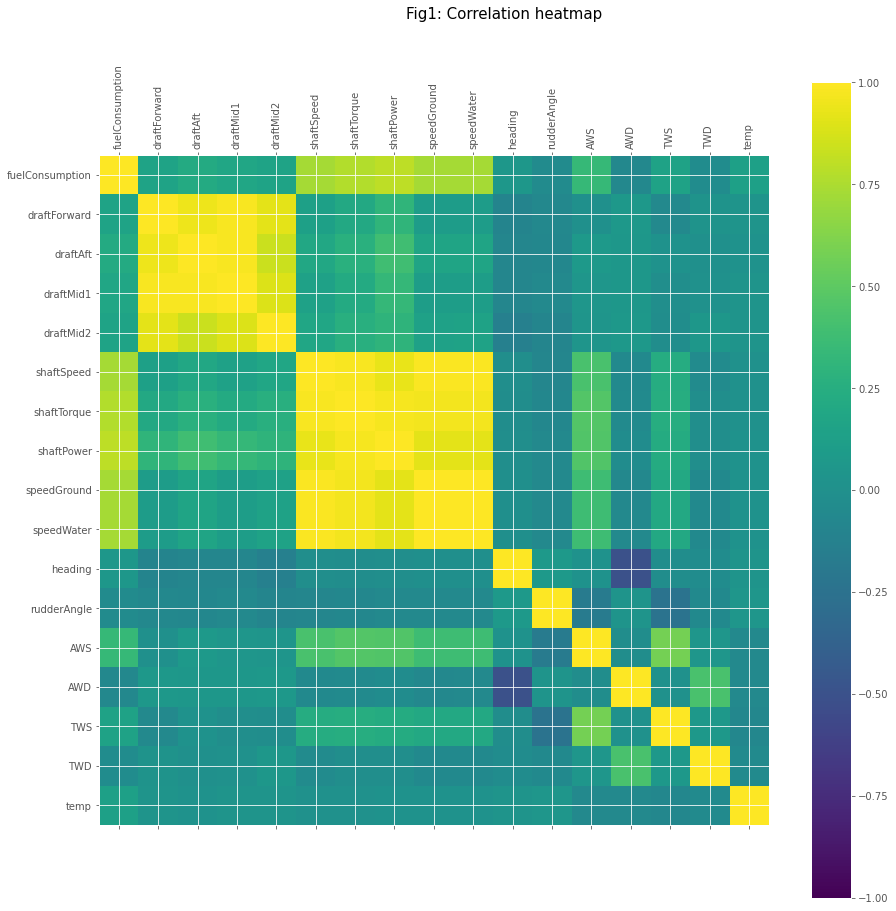

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,17,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df.drop(cols_to_drop, axis=1).columns, rotation=90)
ax.set_yticklabels(df.drop(cols_to_drop, axis=1).columns);
fig.suptitle('Fig1: Correlation heatmap', size=15, y=0.95);

**Skewness of univariate distributions**

In [55]:
df.skew()

fuelConsumption     -0.129
HFO                 -1.635
MGO                  1.718
draftForward         0.049
draftAft            -0.647
draftMid1           -0.170
draftMid2            0.228
shaftSpeed          -0.520
shaftTorque         -0.215
shaftPower           0.059
speedGround         -0.492
speedWater          -0.509
heading             -0.226
rudderAngle         -2.726
AWS                  0.642
AWD                  0.393
TWS                  0.668
TWD                 -0.091
temp               -14.765
currentDirection     0.608
currentSpeed         3.054
waterDepth           3.458
waveHeight           3.095
wavePeriod           2.004
waveDirection        2.356
dtype: float64

### Exploratory data analysis

1. Fig2 shows the distributions of features. 
2. Bimodal distributions are observed for draft, heading and speed features.
3. Sea state features seem to be highly skewed with majority of the values as zero.
4. Fig3 shows

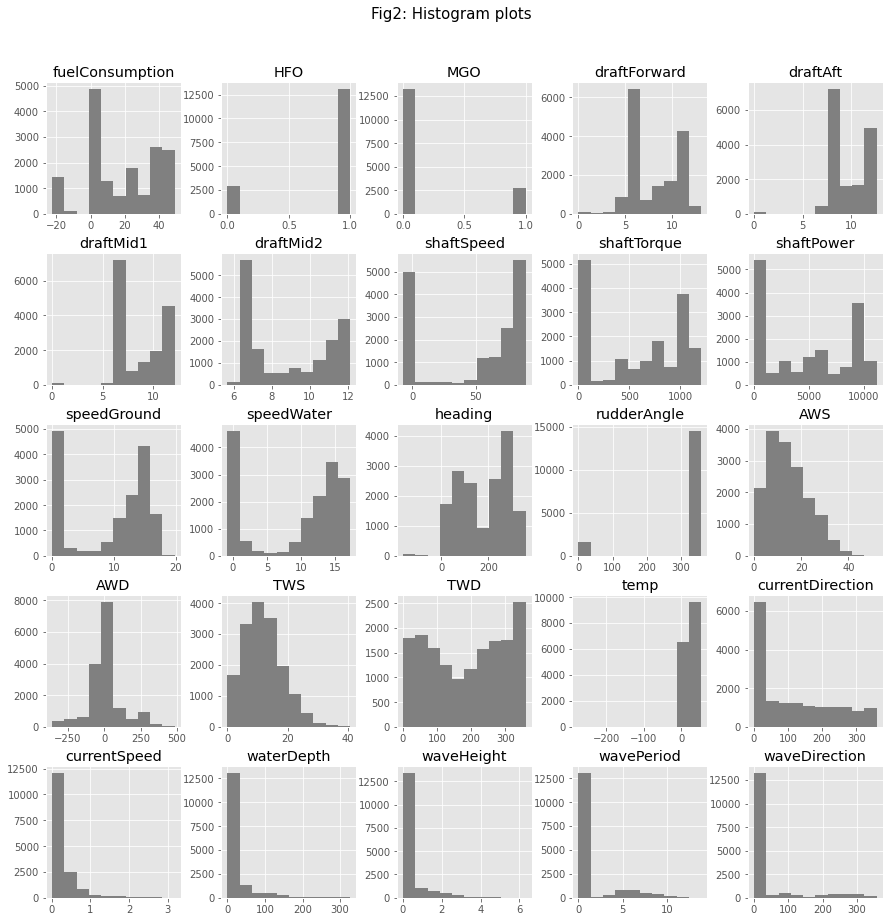

In [75]:
df.hist(color='gray')
plt.suptitle('Fig2: Histogram plots', size=15, y=0.95);

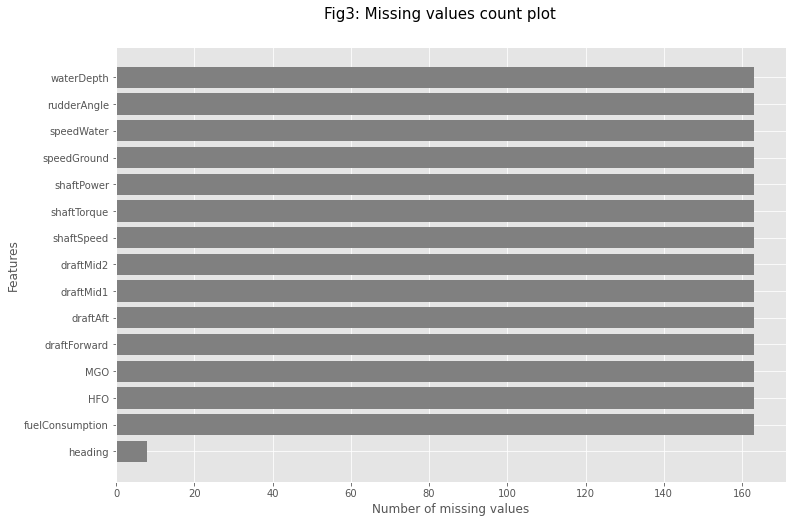

In [85]:
# Missing values count plot
nan_all = df.isna().sum()
missing = nan_all[nan_all != 0].sort_values()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(missing.index, missing.values, color='gray')
ax.set_xlabel("Number of missing values")
ax.set_ylabel("Features")
fig.suptitle('Fig3: Missing values count plot', size=15, y=0.95);

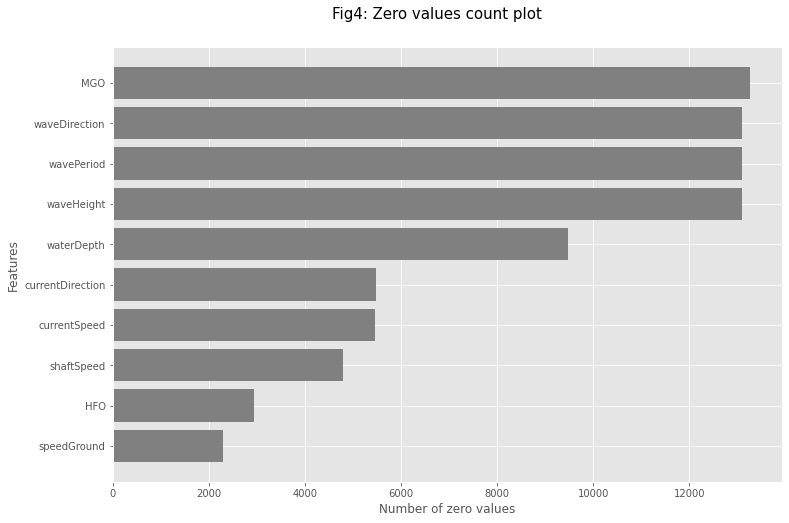

In [86]:
# Zero values counts plot
zeroCounts_all = (df == 0).sum().sort_values()
zeroCounts = zeroCounts_all[zeroCounts_all > 500]

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(zeroCounts.index, zeroCounts.values, color='gray')
ax.set_xlabel("Number of zero values")
ax.set_ylabel("Features")
fig.suptitle('Fig4: Zero values count plot', size=15, y=0.95);

In [24]:
df.dropna(how='any', inplace=True)

In [25]:
df['meanDraft'] = df[['draftAft', 'draftForward', 'draftMid1', 'draftMid2']].mean(axis=1)

In [26]:
# Drop the columns with high number of values zero - MGO, waveDirection, wavePeriod, waveHeight, waterDepth,
# currentDirection, currentSpeed, speedGround. Shaft power is output rather than input, shaft torque is not known
# before, so drop these too. AWS & AWD are dropped as their calculation involves speed of ship.
cols_to_drop = ['MGO', 'draftForward', 'draftAft', 'draftMid1', 'draftMid2', 'shaftTorque', 'shaftPower',
                'speedGround', 'AWS', 'AWD', 'currentDirection', 'currentSpeed', 'waterDepth',
                'waveHeight', 'wavePeriod', 'waveDirection']

df.drop(columns=cols_to_drop, inplace=True)

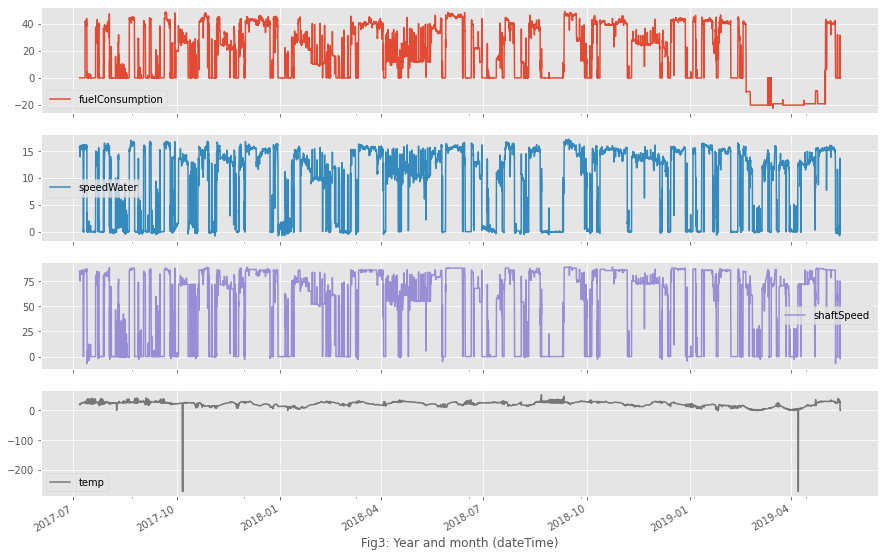

In [27]:
df.loc[:, ['fuelConsumption', 'speedWater', 'shaftSpeed', 'temp']].plot(subplots=True, figsize=(15, 10))
plt.xlabel("Fig3: Year and month (dateTime)");

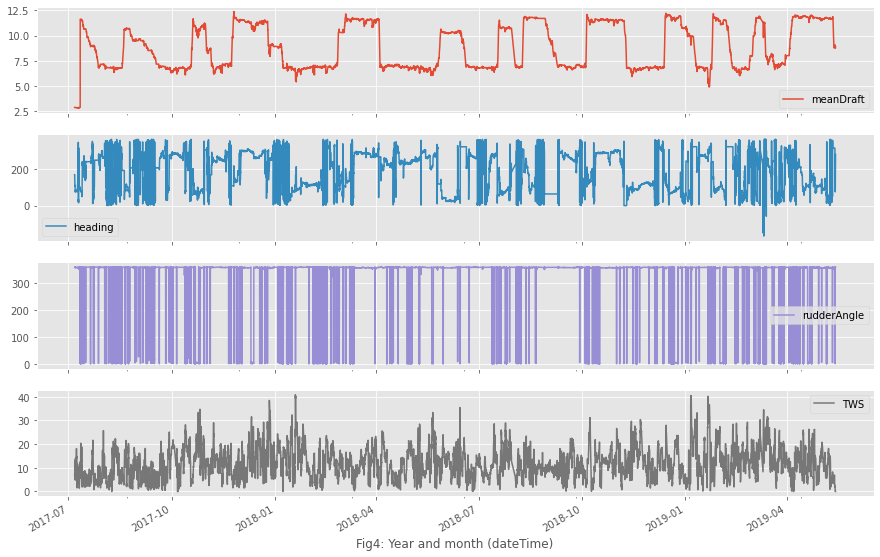

In [28]:
df.loc[:, ['meanDraft', 'heading', 'rudderAngle', 'TWS']].plot(subplots=True, figsize=(15, 10))
plt.xlabel("Fig4: Year and month (dateTime)");

In [32]:
# Summary Statistics - before data cleaning
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fuelConsumption,16084.0,17.182,20.758,-2.257e+01,-0.048,15.922,39.785,49.091
HFO,16084.0,0.816,0.387,0.000e+00,1.000,1.000,1.000,1.000
shaftSpeed,16084.0,50.945,36.676,-7.110e+00,0.000,69.726,85.458,88.959
speedWater,16084.0,9.238,6.549,-8.121e-01,0.387,12.444,15.109,17.187
heading,16084.0,182.710,102.050,-1.646e+02,88.550,205.461,273.357,359.824
rudderAngle,16084.0,323.912,105.071,0.000e+00,357.507,358.605,359.114,359.999
TWS,16084.0,11.934,6.385,0.000e+00,7.261,11.268,15.814,40.846
TWD,16084.0,188.119,113.073,5.676e-04,79.045,199.608,292.352,359.997
temp,16084.0,20.735,13.687,-2.731e+02,16.451,22.683,26.867,52.559
meanDraft,16084.0,8.813,2.170,2.789e+00,6.840,8.090,11.304,12.385


In [34]:
# Drop Absolute temp values (observed < -273), which are likely because of sensor error. Drop negative heading
# values and fuel consumption values < -0.5
conditionEval = (df['heading'] < 0) | (df['temp'] < -273) | (df['fuelConsumption'] < -0.5)
df.drop(df[conditionEval].index, inplace=True)
# Replace the Fuel consumption negative values between -0.5 and 0 with zero. These values are likely to be within
# standard error of measurement. Since shaft speed is zero for these values, it is inferred that the ship is
# docked at port.
df.loc[df['fuelConsumption'] < 0, 'fuelConsumption'] = 0

In [35]:
# Summary Statistics - after data cleaning
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fuelConsumption,14476.0,21.1407,17.8556,0.0000,0.0000,22.2575,40.2183,49.0908
HFO,14476.0,0.8601,0.3464,0.0000,1.0000,1.0000,1.0000,1.0000
shaftSpeed,14476.0,50.8542,36.9418,-7.1103,0.0000,69.0208,85.5162,88.9594
speedWater,14476.0,9.2550,6.6095,-0.8121,0.3988,12.5629,15.1833,17.1869
heading,14476.0,185.9535,101.8591,0.0000,89.9157,214.5876,275.9853,359.8244
rudderAngle,14476.0,325.0095,103.4787,0.0000,357.4654,358.5964,359.1099,359.9992
TWS,14476.0,11.7650,6.3787,0.0000,7.0706,11.0053,15.6360,40.8458
TWD,14476.0,187.4718,113.7822,0.0006,78.3221,196.8934,293.5270,359.9971
temp,14476.0,22.3488,6.4858,-1.0552,18.1012,23.9445,27.0715,52.5592
meanDraft,14476.0,8.7345,2.1545,2.7887,6.8303,7.9261,11.1004,12.3855


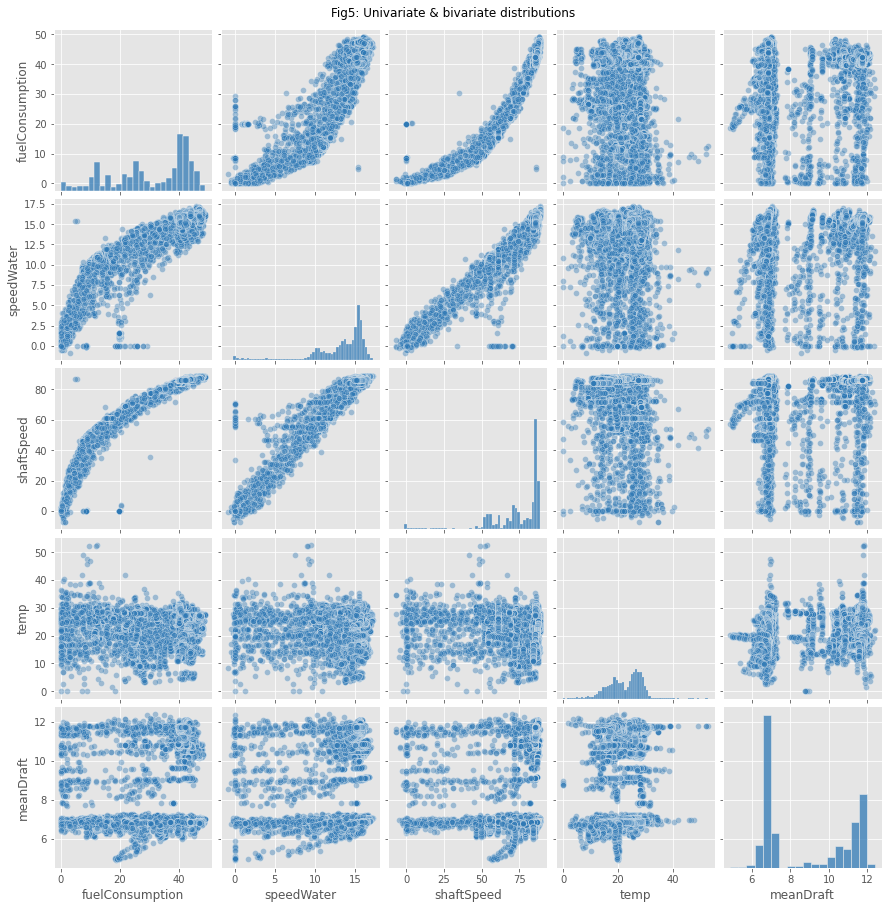

In [37]:
# Pair plot
sns.set_palette("RdBu_r")
g = sns.pairplot(df[df['fuelConsumption'] > 0], vars=['fuelConsumption', 'speedWater', 'shaftSpeed', 'temp', 'meanDraft'],
                 plot_kws={'alpha': 0.4})
g.fig.suptitle("Fig5: Univariate & bivariate distributions",  y=1.01);

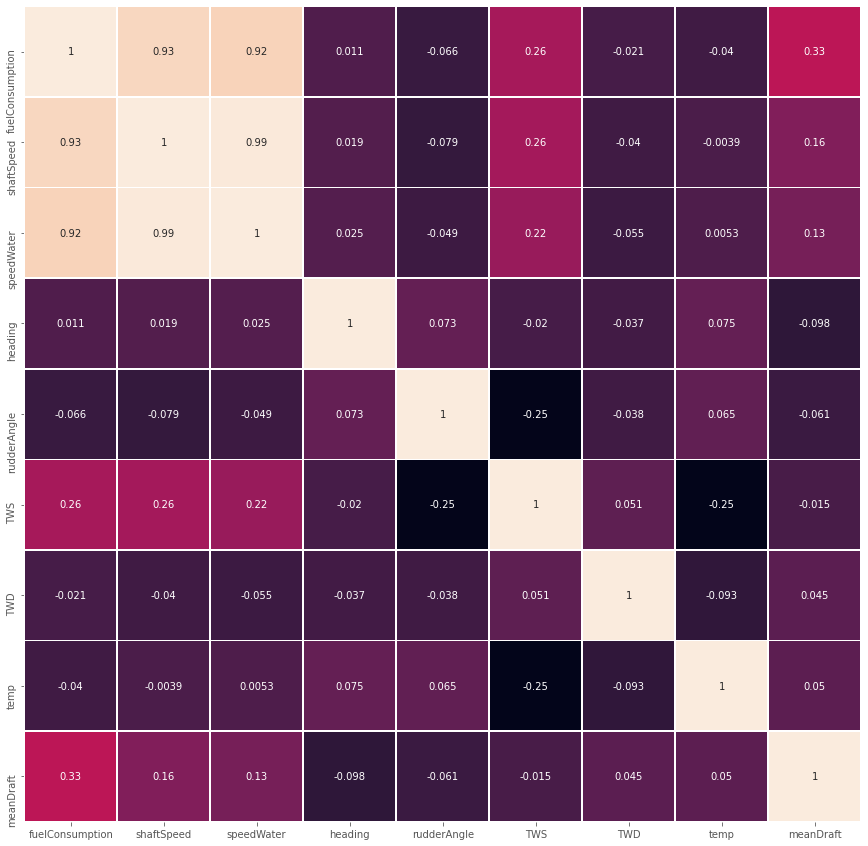

In [38]:
# Correlation Matrix
sns.heatmap(df.drop(columns='HFO').corr(), annot=True, cbar=False, linewidths=0.5);

In [ ]:
df.hist(color='grey');

In [ ]:
# Split-out validation dataset
dataArray = df.values
X = dataArray[:, 1:10]
y = dataArray[:, 0]
validation_size = 0.2
seed = 1
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [ ]:
# Test options and evaluation metric
num_folds = 10
seed = 1
scoring = 'neg_mean_squared_error'

In [ ]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression())) 
models.append(('LASSO', Lasso())) 
models.append(('EN', ElasticNet())) 
models.append(('KNN', KNeighborsRegressor())) 
models.append(('CART', DecisionTreeRegressor())) 
models.append(('SVR', SVR()))

In [ ]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

In [ ]:
# Compare Algorithms
fig = plt.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results, showmeans=True) 
ax.set_xticklabels(names);

In [ ]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())]))) 
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

In [ ]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names);

**Ensembles**

In [ ]:
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))]))) 
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=10))])))
results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

In [ ]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison') 
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names);

**Explore Number of trees and evaluate performance**

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 300, 500, 1000, 1500, 2000]
    for n in n_trees:
        models[str(n)] = ExtraTreesRegressor(n_estimators=n)
    return models

models = get_models()

In [ ]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

results = []
names = []
for name, model in models.items():
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

In [ ]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True);

**Explore number of features**

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # Explore number of features to consider from 1 to 8
    for i in range(1, rescaledX.shape[1]):
        models[str(i)] = ExtraTreesRegressor(max_features=i)
    return models

models = get_models()

In [ ]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

results = []
names = []
for name, model in models.items():
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

In [ ]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True);

**Explore minimum samples per split**

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # Explore minimum samples per split from 2 to 8
    for i in range(2, 9):
        models[str(i)] = ExtraTreesRegressor(min_samples_split=i)
    return models

models = get_models()

In [ ]:
results = []
names = []
for name, model in models.items():
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

In [ ]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True);

**Final Model**

In [ ]:
# prepare the model
model = ExtraTreesRegressor(random_state=seed, 
                            n_estimators=100, 
                            max_features=5, 
                            min_samples_split=5, 
                            n_jobs=14)
model.fit(rescaledX, y_train)

In [ ]:
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(y_validation, predictions))

In [ ]:
import seaborn as sns
sns.scatterplot(x = predictions, y = y_validation);